# Get Conservation Scores

Get PhyloP conservation scores for ensembl transcripts

In [1]:
import pandas as pd
import requests
import sys
from datasets import dataset_list
from tqdm import tqdm
import seaborn as sns

In [14]:
def get_chr_from_refseq(refseq):
    num = int(refseq[-5:-3])
    if num == 23:
        return 'chrX'
    elif num == 24:
        return 'chrY'
    else:
        return 'chr' + str(num)


def get_conservation(refseq, start, end, genome):
    chrom = get_chr_from_refseq(refseq)
    api_url = 'http://api.genome.ucsc.edu/getData/track'
    params = {
        'genome': 'hg38',
        'track': 'phyloP100way',
        'start': start,
        'end': end,
        'chrom': chrom
    }
    results = requests.get(api_url, data=params)
    if results.ok:
        value_df = (pd.DataFrame([pd.Series(x) for x in pd.read_json(results.content.decode('utf8'))[chrom].values])
                    .rename(columns={'value': 'conservation'}))
    else:
        raise ValueError(results.reason)
    return value_df


def build_request_url(ext, server="https://rest.ensembl.org"):
    request_url = "/".join([server, ext])
    return request_url


def handle_results(results):
    if not results.ok:
        results.raise_for_status()
        sys.exit()
    decoded = results.json()
    return decoded


def get_transcript_exons(transcript):
    base_transcript = transcript.split('.')[0]
    request_url = build_request_url("/lookup/id/" + base_transcript + "?expand=1")
    r = requests.get(request_url, headers={"Content-Type": "application/json"})
    decoded = handle_results(r)
    exon_df = pd.DataFrame(decoded['Exon'])
    trans_sr = pd.Series(decoded['Translation'])
    return exon_df, trans_sr


def get_exon_conservation(exon_df, refseq_id):
    conservation_dict = {}
    for i, row in exon_df.set_index('id').iterrows():
        # subtract one since the nucleotide conservation corresponds to the "end" index
        conservation_dict[i] = get_conservation(refseq_id, row['start'] - 1, row['end'])
        # get the conservation of i
    conservation_df = (pd.concat(conservation_dict)
                       .reset_index(level=0)
                       .reset_index(drop=True)
                       .rename({'level_0': 'exon_id',
                                'end': 'genomic position'}, axis=1)
                       .drop('start', axis=1))
    return conservation_df


def get_transcript_conservation(transcript_id, refseq_id, target_strand):
    exon_df, trans_sr = get_transcript_exons(transcript_id)
    # only include translated positions
    exon_df['start'] = exon_df['start'].apply(lambda x: max(x, trans_sr['start']))
    exon_df['end'] = exon_df['end'].apply(lambda x: min(x, trans_sr['end']))
    conservation_df = get_exon_conservation(exon_df, refseq_id)
    conservation_df['Transcript Base'] = transcript_id
    if target_strand == '-':
        ascending = False
    else:
        ascending = True
    conservation_df = (conservation_df
                       .sort_values('genomic position', ascending=ascending)
                       .reset_index(drop=True))
    conservation_df['target position'] = conservation_df.index + 1
    return conservation_df


In [3]:
data_list = list()
for ds in dataset_list:
    if ds.endogenous:
        data_list.append(ds)

design_list = list()
for ds in tqdm(data_list):
    ds.load_data()
    ds.set_sgrnas()
    design_list.append(ds.get_designs())

100%|██████████| 8/8 [00:26<00:00,  3.26s/it]


In [4]:
design_df = (pd.concat(design_list)
             .drop_duplicates())
transcript_refseq_df = (design_df[['Target Transcript', 'Reference Sequence', 'Strand of Target']]
                        .drop_duplicates())
transcript_refseq_df['Transcript Base'] = (transcript_refseq_df['Target Transcript']
    .str.split('.', expand=True)[0])
len(transcript_refseq_df)

2998

In [17]:
transcript_conservation_list = []
failed_list = []
for i, row in tqdm(transcript_refseq_df.iterrows()):
    try:
        transcript_conservation_list.append(get_transcript_conservation(row['Transcript Base'],
                                                                        row['Reference Sequence'],
                                                                        row['Strand of Target']))
    except:
        failed_list.append(row)

2998it [00:02, 1494.80it/s]


(0, Target Transcript     ENST00000371588.9
Reference Sequence         NC_000020.11
Strand of Target                      -
Transcript Base         ENST00000371588
Name: 0, dtype: object)
(6, Target Transcript     ENST00000374811.7
Reference Sequence         NC_000023.11
Strand of Target                      -
Transcript Base         ENST00000374811
Name: 6, dtype: object)
(12, Target Transcript     ENST00000570319.5
Reference Sequence         NC_000016.10
Strand of Target                      -
Transcript Base         ENST00000570319
Name: 12, dtype: object)
(18, Target Transcript     ENST00000262803.9
Reference Sequence         NC_000019.10
Strand of Target                      +
Transcript Base         ENST00000262803
Name: 18, dtype: object)
(24, Target Transcript     ENST00000225296.8
Reference Sequence         NC_000017.11
Strand of Target                      -
Transcript Base         ENST00000225296
Name: 24, dtype: object)
(30, Target Transcript     ENST00000261643.8
Reference

In [20]:
get_transcript_conservation(row['Transcript Base'],
                                                                        row['Reference Sequence'],
                                                                        row['Strand of Target'])

TypeError: tuple indices must be integers or slices, not str

In [7]:
test_df[test_df['exon_id'] == 'ENSE00001455614']

,exon_id,genomic position,conservation,Transcript Base,target position
0,ENSE00001455614,50958532.0,0.892551,ENST00000371588,1
1,ENSE00001455614,50958531.0,0.330780,ENST00000371588,2
2,ENSE00001455614,50958530.0,0.555488,ENST00000371588,3
3,ENSE00001455614,50958529.0,1.679030,ENST00000371588,4
4,ENSE00001455614,50958528.0,1.229610,ENST00000371588,5
...,...,...,...,...,...
165,ENSE00001455614,50958367.0,3.139640,ENST00000371588,166
166,ENSE00001455614,50958366.0,6.847330,ENST00000371588,167
167,ENSE00001455614,50958365.0,1.229610,ENST00000371588,168
168,ENSE00001455614,50958364.0,4.937310,ENST00000371588,169


<AxesSubplot:xlabel='conservation', ylabel='Count'>

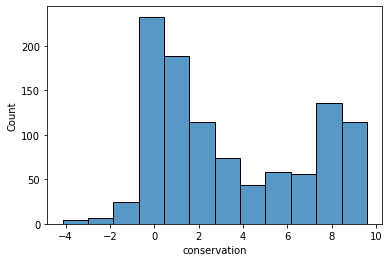

In [8]:
sns.histplot(test_df['conservation'])

In [9]:
test_df.reindex(test_df.index[::-1])

,exon_id,genomic position,conservation,Transcript Base,target position
1053,ENSE00003900401,50934870.0,-0.170638,ENST00000371588,1054
1052,ENSE00003900401,50934871.0,2.313270,ENST00000371588,1053
1051,ENSE00003900401,50934872.0,1.174810,ENST00000371588,1052
1050,ENSE00003900401,50934873.0,0.346843,ENST00000371588,1051
1049,ENSE00003900401,50934874.0,1.174810,ENST00000371588,1050
...,...,...,...,...,...
4,ENSE00001455614,50958528.0,1.229610,ENST00000371588,5
3,ENSE00001455614,50958529.0,1.679030,ENST00000371588,4
2,ENSE00001455614,50958530.0,0.555488,ENST00000371588,3
1,ENSE00001455614,50958531.0,0.330780,ENST00000371588,2


In [10]:
50935236 - 50958363.0

-23127.0

In [11]:
test = pd.DataFrame({'a': [1,2,2,3]})

In [12]:
test.reindex(index=test.index[::-1])

,a
3,3
2,2
1,2
0,1


In [13]:
test.iloc[::-1].reset_index(drop=True)

,a
0,3
1,2
2,2
3,1
